In [1]:
import pandas as pd

In [3]:
full_df = pd.read_csv('../dataset/complete_dataset.csv')
full_df.drop_duplicates(subset=['IMDB_ID'], inplace=True)

In [50]:
from pathlib import Path
import numpy as np
def read_embeddings(embedding_file: str):
    data = Path(embedding_file).read_text()
    lines = data.split('\n')
    filenames = []
    embeddings = []
    for line in lines:
        line_data = line.split(' ')
        if len(line_data) >=2 :
            filenames.append(line_data[0])
            embeddings.append(list(map(float, line_data[1:])))
    return np.asarray(filenames), np.asarray(embeddings)

In [51]:
filenames, embeddings = read_embeddings('../dataset/embeddings.txt')

In [52]:
filenames.shape, embeddings.shape

((3729,), (3729, 300))

In [8]:
df = full_df[full_df['filename'].isin(filenames)].copy()
df.shape

(3729, 19)

In [9]:
df.head()

,filename,text,IMDB_ID,genre,year,production_region,corpus,duration,directors,writers,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
706,6416324.xml,Der Roman von Alexandre Dumas dem Älteren hatt...,tt1104767,"Adventure,Drama,History",1943.0,French,untokenisiert,90,"nm0894509,nm0148602","nm0241416,nm0816458,nm0763376,nm0812731",movie,The Count of Monte Cristo - Part 2: Retribution,"Le comte de Monte Cristo, 2ème époque: Le chât...",0.0,1943.0,NaN,90,7.0,80.0
2784,4732286.xml,Hände hoch oder ich schieße ( 1966 ) dTV - MDR...,tt1631717,Comedy,1966.0,German,untokenisiert,75,nm0440757,"nm0440757,nm0833141,nm1127102",movie,Hände hoch oder ich schieße,Hände hoch oder ich schieße,0.0,1966.0,NaN,75,5.8,36.0
3085,6122081.xml,"Hallo , Manuela ? Störe ich ? Kann ich zu dir ...",tt1271979,Drama,1967.0,French,untokenisiert,78,nm0816215,nm0816215,movie,La lune avec les dents,La lune avec les dents,0.0,1967.0,NaN,78,7.0,34.0
6044,5594522.xml,Dein Vater war ein ausgezeichneter Kämpfer . A...,tt3141954,"Action,Adventure",1978.0,Cantonese,untokenisiert,82,nm1172472,NaN,movie,Brawl Busters,Sa-dae-tong-iue-moon,0.0,1978.0,NaN,82,6.2,31.0
6281,5618549.xml,"Na los , iss jetzt schnell auf . Junge , ist d...",tt1065116,Action,1979.0,Japanese,untokenisiert,96,nm0814232,"nm0032816,nm0793999,nm0814232",movie,Sûpâ gun redei Wani Bunsho,Sûpâ gun redei Wani Bunsho,0.0,1979.0,NaN,96,5.7,44.0


In [10]:
# check if everything is in right order for joining data
(df.filename == filenames).all()

True

In [11]:
df['embedding'] = [e for e in embeddings]

In [12]:
from umap import UMAP

reducer = UMAP(n_neighbors=15)

Xr = reducer.fit_transform(embeddings)

In [40]:
import re
df.production_region = df.production_region.fillna("Unknown")
df['main_region'] = [
    'English' if "English" in list(map(lambda x: re.sub(r'\s+','', x), production_region.split(','))) else "Other" for production_region in df.production_region
]

In [42]:
df.genre = df.genre.fillna("Unknown")
df['main_genre'] = df.genre.str.split(',').apply(lambda x: x[0])

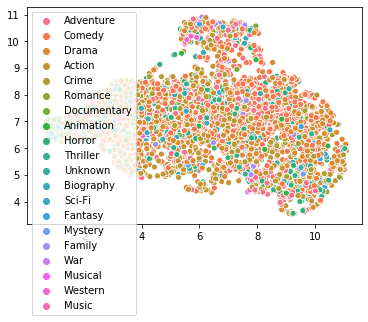

In [43]:
import seaborn as sns
sns.scatterplot(x=Xr[:,0], y=Xr[:,1], hue=list(map(lambda x: x, df.main_genre)))

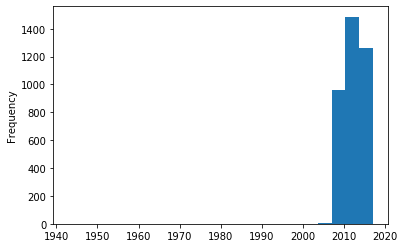

In [21]:
df.year.plot(kind="hist", bins=len(df.year.unique()))

In [53]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(embeddings, df.main_genre)
clf = LinearSVC().fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Action       0.58      0.82      0.68       201
   Adventure       0.31      0.06      0.10        64
   Animation       0.00      0.00      0.00        13
   Biography       0.50      0.03      0.05        37
      Comedy       0.58      0.73      0.65       218
       Crime       0.67      0.04      0.08        50
 Documentary       0.61      0.50      0.55        22
       Drama       0.48      0.70      0.57       225
      Family       0.00      0.00      0.00         6
     Fantasy       0.00      0.00      0.00         3
      Horror       0.71      0.17      0.27        59
     Mystery       0.00      0.00      0.00         8
     Romance       0.00      0.00      0.00         6
      Sci-Fi       0.00      0.00      0.00         3
    Thriller       0.00      0.00      0.00        13
     Unknown       0.00      0.00      0.00         2
         War       0.00      0.00      0.00         2
     Western       0.00    

/Users/lennartkeller/opt/anaconda3/envs/clustering/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
X_test

array([['-0.08226086', '0.11429174', '-0.14907911', ..., '0.04448671',
        '0.040436532', '0.12975243'],
       ['-0.08615663', '0.12003469', '-0.14018029', ..., '0.047964353',
        '0.028829051', '0.13419618'],
       ['-0.073069304', '0.12450612', '-0.1470513', ..., '0.060947094',
        '0.045914277', '0.11790051'],
       ...,
       ['-0.07089581', '0.13080198', '-0.14988206', ..., '0.043674584',
        '0.039334167', '0.11898424'],
       ['-0.05605495', '0.15749432', '-0.14052102', ..., '0.05081059',
        '0.046254344', '0.12405323'],
       ['-0.06927359', '0.13211535', '-0.15428193', ..., '0.041307807',
        '0.02445372', '0.13661407']], dtype='<U15')